<a href="https://colab.research.google.com/github/ads-predict-early-alzheimers/project/blob/main/project_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's prediction

## What is Alzheimer's disease (AD)?

Alzheimer's disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens.It is the cause of 60–70% of cases of dementia.The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, self-neglect, and behavioral issues. As a person's condition declines, they often withdraw from family and society.Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years.

## What is Dementia?

Dementia is a general term for loss of memory, language, problem-solving and other thinking abilities that are severe enough to interfere with daily life. Alzheimer's is the most common cause of dementia, a general term for memory loss and other cognitive abilities serious enough to interfere with daily life. Alzheimer's disease accounts for 60-80% of dementia cases.

### Our problem statement

Estimating the CDR (scale of Dementia) using relevant features in the MRI dataset.

The CDR is based on a scale of 0–3: no dementia (CDR = 0), questionable dementia (CDR = 0.5), MCI (CDR = 1), moderate cognitive impairment (CDR = 2), and severe cognitive impairment (CDR = 3).

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

## Reading the Cross-sectional and Longitudinal MRI datasets.

We describe the attributes in the dataset with data_cross.info() and data_long.info()

In [2]:
import requests
import pandas as pd
import io

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_cross-sectional.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

cross_content = response.content.decode('utf-8')
data_cross = pd.read_csv(io.StringIO(cross_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [3]:
import requests
import pandas as pd

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_longitudinal.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

long_content = response.content.decode('utf-8')
data_long = pd.read_csv(io.StringIO(long_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [4]:
print(data_cross.info())
print(data_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

## Checking for null values.

In [5]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64




Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Since we will be predicting on the variable "CDR", we drop all the rows with undefined or null values

In [6]:
data_cross.dropna(subset=['CDR'],inplace=True)

## Removing unnecessary columns in both datasets.
The unique columns would be of no use in estimating the dependent variable "CDR"

In [7]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

## Appending both the datasets.

In [8]:
data = pd.concat([data_cross,data_long])
data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [9]:
data.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,608.000000,608.000000,570.00000,606.000000,608.000000,608.000000,608.00000,608.000000
mean,75.208882,10.184211,2.47193,27.234323,0.288651,1477.062500,0.73713,1.203597
std,9.865026,6.058388,1.12805,3.687980,0.377697,170.653795,0.04267,0.135091
min,33.000000,1.000000,1.00000,4.000000,0.000000,1106.000000,0.64400,0.876000
25%,70.000000,4.000000,2.00000,26.000000,0.000000,1352.500000,0.70400,1.118000
50%,76.000000,12.000000,2.00000,29.000000,0.000000,1460.000000,0.73600,1.202000
75%,82.000000,16.000000,3.00000,30.000000,0.500000,1569.000000,0.76625,1.297500
max,98.000000,23.000000,5.00000,30.000000,2.000000,2004.000000,0.84700,1.587000


DATA EDA TO UNDERSTAND BASIC STASTICS AND DISTRIBUTIONS OF THE DATASET. 

This is the first step in the data analysis process to get some knowledge about the dataset before we start performing data preprocessing. We can find certain patterns and distributions of the dataset which can further help us in training the model on this dataset in future. 


a. Describe the data used by this ADS. How was this data collected or selected?

b. For each input feature, describe its datatype, give information on missing values and on the value distribution. Show pairwise correlations between features if appropriate. Run any other reasonable profiling of the input that you find interesting and appropriate.

c. What is the output of the system (e.g., is it a class label, a score, a probability, or some other type of output), and how do we interpret it? 

Lets make a function which gives us a basic description of the dataset. This function would provide us with the following info about each numeric feature in data.

1. Mean, Median, Min and Max value. Also we will show the box-plot for the feature. Boxplots shows the distribution of the feature
2. Datatypes.
3. Number of missing values.

Also we will be showing the pairwise correlations between features of the data. 


In [10]:
import matplotlib.pyplot as plt

def mydescriber(data):
  #fig, ax = plt.subplots(2,4,figsize=(30,12))
  column_names = ['Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF']
  print(column_names)
  for n, f in enumerate(column_names):
    print("Feature Name : ",f)
    if(pd.api.types.is_numeric_dtype(data[f]) == True):
      print("Mean : ",data[f].mean())
      print("Median : ",data[f].median())
      print("Min Value : ",data[f].min())
      print("Max Value : ",data[f].max())
      #plt.boxplot(data[f],whis=[5, 95])
      #ax[int(np.floor(n/4)),n%4].set_title(f)

In [11]:
mydescriber(data)

['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Feature Name :  Age
Mean :  75.20888157894737
Median :  76.0
Min Value :  33
Max Value :  98
Feature Name :  Educ
Mean :  10.18421052631579
Median :  12.0
Min Value :  1.0
Max Value :  23.0
Feature Name :  SES
Mean :  2.4719298245614034
Median :  2.0
Min Value :  1.0
Max Value :  5.0
Feature Name :  MMSE
Mean :  27.234323432343235
Median :  29.0
Min Value :  4.0
Max Value :  30.0
Feature Name :  CDR
Mean :  0.2886513157894737
Median :  0.0
Min Value :  0.0
Max Value :  2.0
Feature Name :  eTIV
Mean :  1477.0625
Median :  1460.0
Min Value :  1106
Max Value :  2004
Feature Name :  nWBV
Mean :  0.7371299342105263
Median :  0.736
Min Value :  0.644
Max Value :  0.847
Feature Name :  ASF
Mean :  1.2035970394736843
Median :  1.202
Min Value :  0.876
Max Value :  1.587


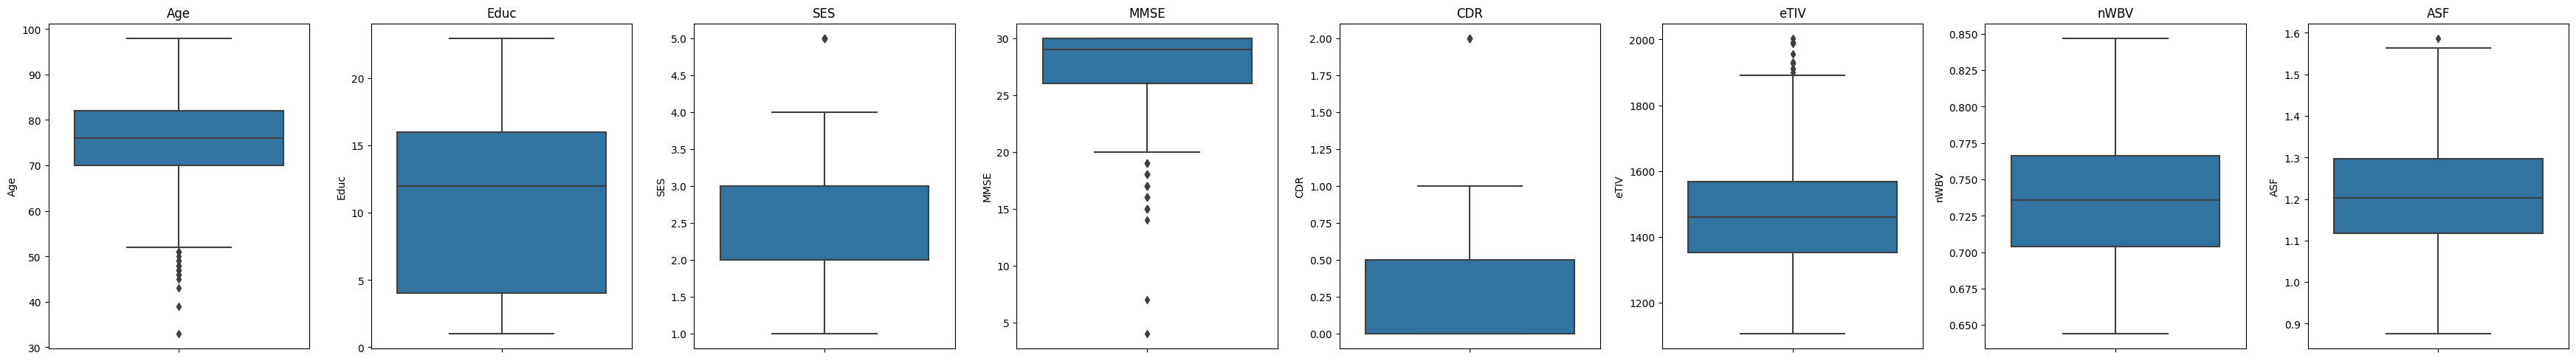

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
column_names = ['Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF']
fig, axes = plt.subplots(nrows=1, ncols=len(column_names), figsize=(35, 5)) # Adjust figsize as needed

for i, col in enumerate(column_names):
    sns.boxplot(y=data[col], ax=axes[i])
    axes[i].set_title(col)  

plt.tight_layout()
plt.show()

<ipython-input-13-171ade5bf97a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


<Axes: >

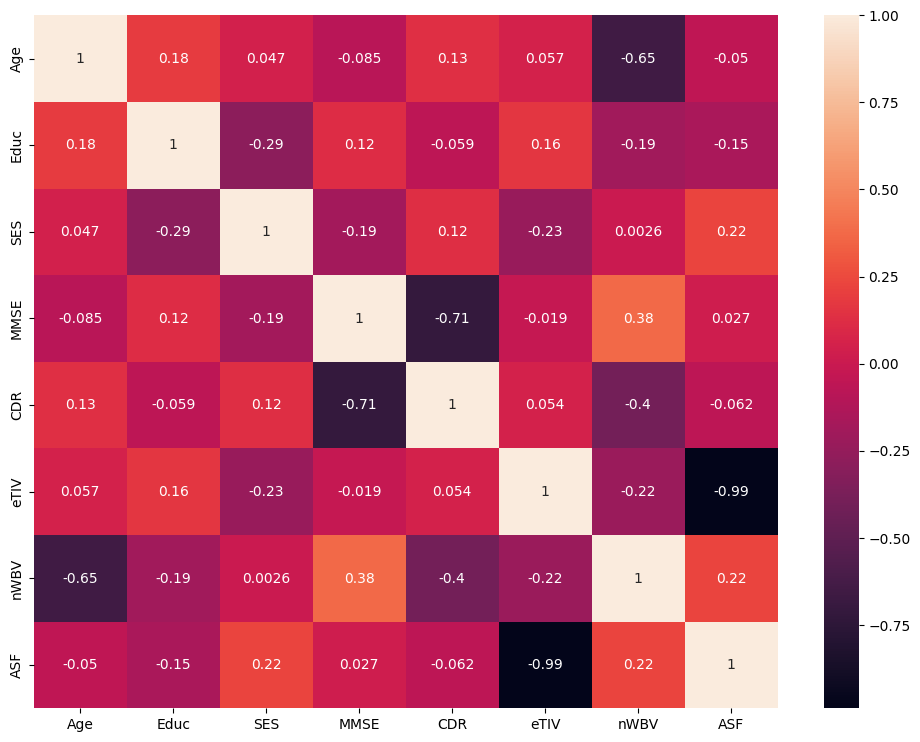

In [13]:
cor = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, xticklabels=cor.columns.values,yticklabels=cor.columns.values, annot=True)


In [14]:
data.isna().sum()

M/F      0
Hand     0
Age      0
Educ     0
SES     38
MMSE     2
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [15]:
data.dtypes

M/F      object
Hand     object
Age       int64
Educ    float64
SES     float64
MMSE    float64
CDR     float64
eTIV      int64
nWBV    float64
ASF     float64
dtype: object

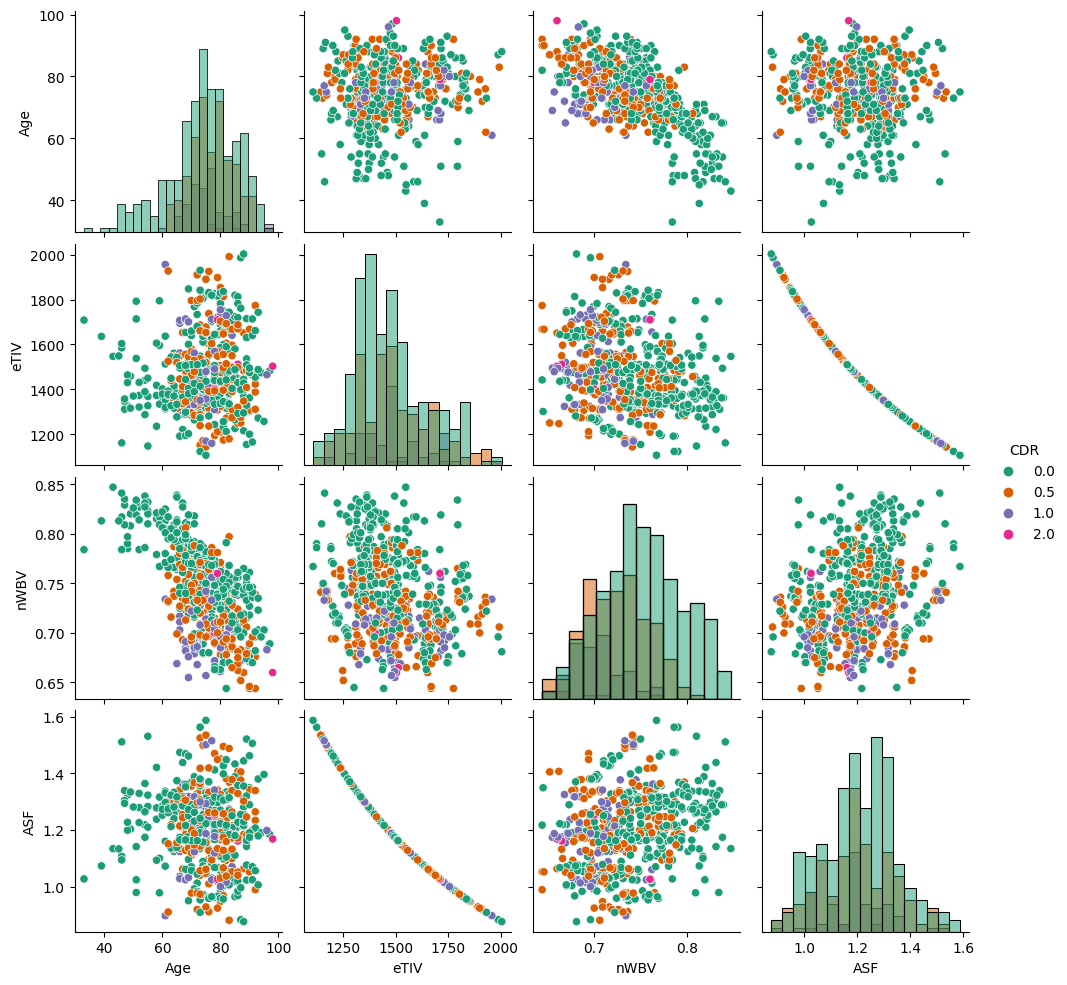

In [16]:
continous_features = ['Age','eTIV','nWBV','ASF','CDR']
custom_palette = ['red','blue','grey','green']
sns.pairplot(data[continous_features], hue='CDR', diag_kind='hist',palette='Dark2')

Lets look at the distributions of each varibles in respect to the target variable 'CDR'.

[Text(0, 0, 'Female'), Text(1, 0, 'Male')]

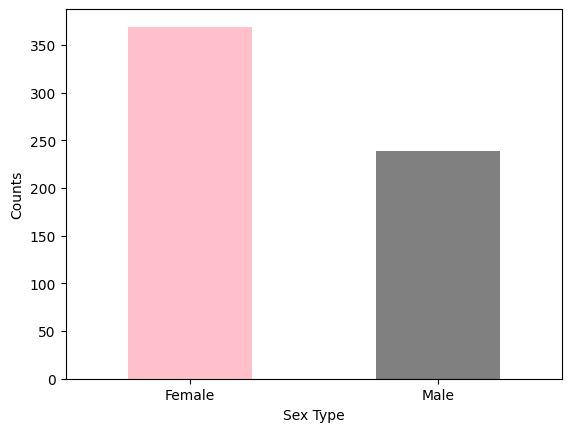

In [17]:
sex_counts = data['M/F'].value_counts()
colors = ['pink', 'grey']
fig,ax = plt.subplots()
ax = sex_counts.plot(kind='bar',xlabel='Sex Type',ylabel='Counts',color=colors)
ax.set_xticklabels(['Female', 'Male'], rotation=0)

Text(0, 0.5, 'Count')

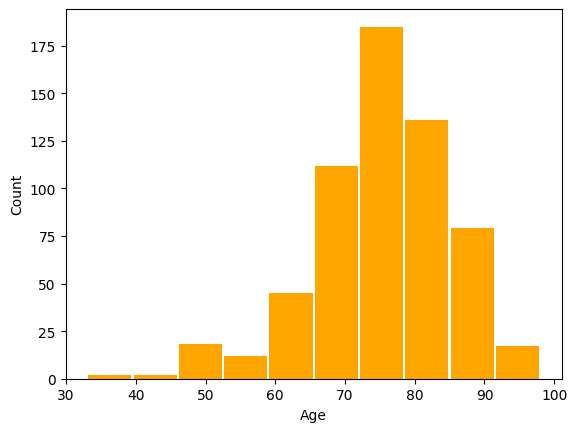

In [18]:
age_counts = data['Age'].value_counts()
fig,ax = plt.subplots()
ax.hist(data['Age'],bins=10,rwidth=0.95,color='orange')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

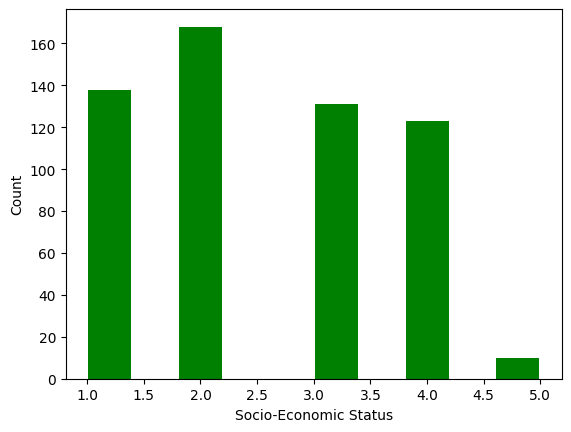

In [19]:
ses_counts = data['SES'].value_counts()
fig,ax = plt.subplots()
ax.hist(data['SES'],bins=10,rwidth=0.95,color='green')
ax.set_xlabel('Socio-Economic Status')
ax.set_ylabel('Count')

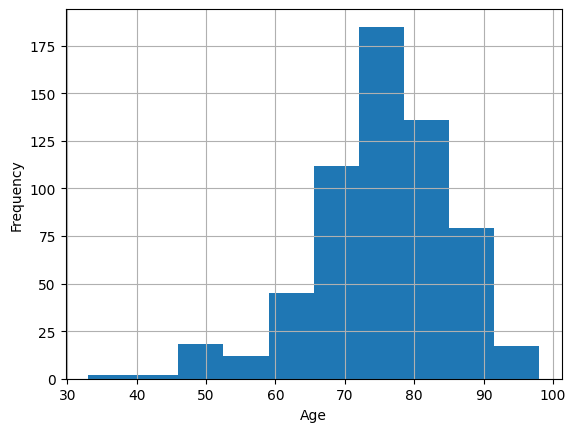

In [20]:
# TODO: write code to plot the distribution of age, race, and sex
# in this code cell

import matplotlib.pyplot as plt
import numpy as np

x = np.random.normal(170, 10, 250)

plt.hist(data["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid()
plt.show()

## Imputing columns using SimpleImputer.
We fill in the missing values in the "SES" columns with the most occuring data element.
Similarly, we fill the missing values in the "MMSE" column with the median of that column.

In [21]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [22]:
data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
368,M,R,82,16.0,1.0,28.0,0.5,1693,0.694,1.037
369,M,R,86,16.0,1.0,26.0,0.5,1688,0.675,1.040
370,F,R,61,13.0,2.0,30.0,0.0,1319,0.801,1.331
371,F,R,63,13.0,2.0,30.0,0.0,1327,0.796,1.323


In [24]:
for i, col_type in enumerate(data.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            data.columns[i],
            data[data.columns[i]].unique()))


Variable M/F takes the values: ['F' 'M']

Variable Hand takes the values: ['R']


## Encoding the Target variable using LabelEncoder.

In [25]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['CDR'] = le.fit_transform(data['CDR'].values)

Converting categorical variables to numeric using OneHot encoding.

In [26]:
data = pd.get_dummies(data)

## Plotting the distribution of classes on a barplot.

<BarContainer object of 4 artists>

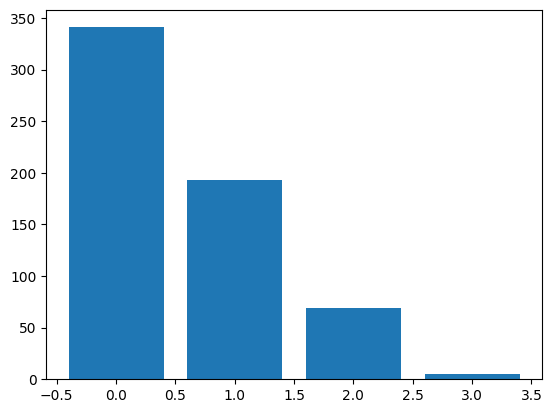

In [27]:
plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

Neglecting the last class due to negligible size in the combined dataset.

In [28]:
data = data.drop(data[data['CDR']==3].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 372
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     599 non-null    int64  
 1   Educ    599 non-null    float64
 2   SES     599 non-null    float64
 3   MMSE    599 non-null    float64
 4   CDR     599 non-null    int64  
 5   eTIV    599 non-null    int64  
 6   nWBV    599 non-null    float64
 7   ASF     599 non-null    float64
 8   M/F_F   599 non-null    uint8  
 9   M/F_M   599 non-null    uint8  
 10  Hand_R  599 non-null    uint8  
dtypes: float64(5), int64(3), uint8(3)
memory usage: 43.9 KB


In [29]:
y = data.pop('CDR')
x = data

## Normalizing the data.
We observe that different columns have different ranges of values. We use Z-score normalization in this case.

In [30]:
x = StandardScaler().fit_transform(x)

## Dividing dataset into train and test sets.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

## Defining Models.



```
# This is formatted as code
```

### 1. We will try hyperparameter tuning using cross-validation for XGBClassifier.

In [32]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }

model_xgb= XGBClassifier(eval_metric='mlogloss')


xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

{'n_estimators': 583, 'max_depth': 5, 'learning_rate': 0.5}

In [33]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

0.7722222222222223

### 2. Trying hyperparameter tuning of GradientBoostingClassifier.

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
FOLDS =10

parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "squared_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
gb_random.fit(X_train, y_train)

gb_random.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


{'subsample': 0.95,
 'n_estimators': 96,
 'min_samples_split': 0.15,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 50,
 'loss': 'deviance',
 'learning_rate': 0.15,
 'criterion': 'friedman_mse'}

In [35]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

0.7611111111111111


GradientBoosting model performs better than XGboost, Hence we try 10-fold cross validation on GradientBoostingClassifier model to improve accuracy.

In [36]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

0.7947175141242937

### Making predictions using the best estimator and plotting the confusion matrix along with classification report.

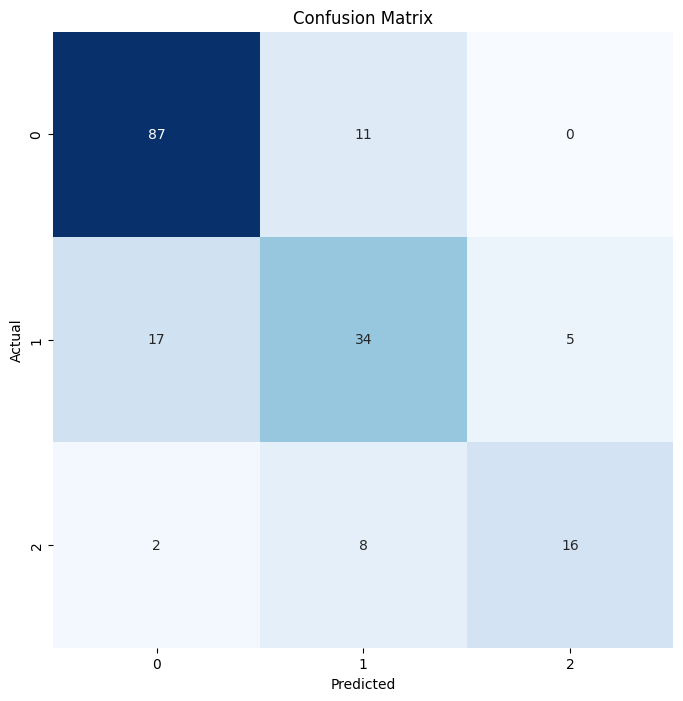

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.82      0.89      0.85        98
           1       0.64      0.61      0.62        56
           2       0.76      0.62      0.68        26

    accuracy                           0.76       180
   macro avg       0.74      0.70      0.72       180
weighted avg       0.76      0.76      0.76       180



In [37]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_tp_fn(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp_fn = []
    
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        tp_fn.append((tp, fn))
    
    return tp_fn

tp_fn = calculate_tp_fn(y_test, y_pred)

for i, (tp, fn) in enumerate(tp_fn):
    print(f"Class {i}: TP = {tp}, FN = {fn}")


Class 0: TP = 87, FN = 11
Class 1: TP = 34, FN = 22
Class 2: TP = 16, FN = 10


In [41]:
%%capture
#@markdown

!pip install fairlearn!

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
import matplotlib.ticker as ticker

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

from IPython.display import clear_output 

# Train Logistic Regression Classifier
Next, we will split our data into training and test sets randomly.  Then, we will train a logistic regression classifier and evaluate possible biases within that classifier.

In [79]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf_score = clf.score(X_test, y_test)
print(f'Logistic Regression test accuracy: {clf_score:.4f}')

Logistic Regression test accuracy: 0.7056


## Evaluate fairness

In [81]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (419, 10)
X_test shape: (180, 10)
y_train shape: (419,)
y_test shape: (180,)


Next, we will evaluate the fairness of our classifier on the test set.  We will first focus on two metrics - demographic parity difference and demographic parity ratio.  Demographic parity difference is defined as the difference between the largest and the smallest group-level selection rate across all values of the sensitive feature(s).  A demographic parity difference of 0 means that all groups have the same selection rate.  Demographic parity ratio is defined as the ratio between the smallest and the largest group-level selection rate across all values of the sensitive feature(s).  A demographic parity ratio of 1 means that all groups have the same selection rate.

In Summary: let $X$ denote a feature vector used for predictions, $A$ be a single sensitive feature (such as age or race), $Y$ be the true label, and $h$ a classifier or predictor resulted from a Machine Learning algorithm. Then:

*Demographic Parity difference* is defined as $(max_a\mathbb{E}[h(X)]~|~  A = a)~ - ~ (min_a\mathbb{E}[h(X)]~|~  A = a) $


*Demographic Parity ratio* is defined as $\frac{max_a\mathbb{E}[h(X)~|~  A = a]}{min_a\mathbb{E}[h(X)~|~  A = a]} $

In [82]:
X_test

array([[ 1.92047912, -0.85932198, -1.31402323, ...,  0.80631119,
        -0.80631119,  0.        ],
       [-0.22325208,  1.2950696 , -0.40302796, ..., -1.24021595,
         1.24021595,  0.        ],
       [-0.0190872 ,  0.96362474, -1.31402323, ..., -1.24021595,
         1.24021595,  0.        ],
       ...,
       [-0.0190872 , -1.35648926,  0.50796731, ...,  0.80631119,
        -0.80631119,  0.        ],
       [-2.77531302, -1.02504441, -0.40302796, ..., -1.24021595,
         1.24021595,  0.        ],
       [ 1.20590205,  0.63217988, -1.31402323, ...,  0.80631119,
        -0.80631119,  0.        ]])

In [83]:
data

,Age,Educ,SES,MMSE,eTIV,nWBV,ASF,M/F_F,M/F_M,Hand_R
0,74,2.0,3.0,29.0,1344,0.743,1.306,1,0,1
1,55,4.0,1.0,29.0,1147,0.810,1.531,1,0,1
2,73,4.0,3.0,27.0,1454,0.708,1.207,1,0,1
8,74,5.0,2.0,30.0,1636,0.689,1.073,0,1,1
9,52,3.0,2.0,30.0,1321,0.827,1.329,1,0,1
...,...,...,...,...,...,...,...,...,...,...
368,82,16.0,1.0,28.0,1693,0.694,1.037,0,1,1
369,86,16.0,1.0,26.0,1688,0.675,1.040,0,1,1
370,61,13.0,2.0,30.0,1319,0.801,1.331,1,0,1
371,63,13.0,2.0,30.0,1327,0.796,1.323,1,0,1


In [91]:
# Assuming your list of feature column names is called 'feature_columns'
female_column_index = list(data.columns).index('M/F_F')
male_column_index = list(data.columns).index('M/F_M')

# Access the one-hot encoded sensitive feature data
female_encoded = X_test[:, female_column_index]
male_encoded = X_test[:, male_column_index]

# Combine the one-hot encoded data into a single sensitive feature array
sensitive_feature = np.where(female_encoded == 1, 'female', 'male')


In [93]:
sensitive_feature

array(['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
       'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male',
      

In [92]:
# Compute demographic parity difference and demographic parity ratio
pred_y = clf.predict(X_test)
demo_parity_diff = demographic_parity_difference(y_test, pred_y, sensitive_features=sensitive_feature)
demo_parity_ratio = demographic_parity_ratio(y_test, pred_y, sensitive_features=sensitive_feature)

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

# Compute selection rate for males and females
male_indices = male_encoded == 1
female_indices = female_encoded == 1

def safe_selection_rate(y_true, pred_y):
    if len(pred_y) == 0:
        return float('nan')
    return selection_rate(y_true, pred_y)

male_y_test = y_test[male_indices]
male_pred_y = pred_y[male_indices]
female_y_test = y_test[female_indices]
female_pred_y = pred_y[female_indices]

male_selection_rate = safe_selection_rate(male_y_test, male_pred_y)
female_selection_rate = safe_selection_rate(female_y_test, female_pred_y)

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')


Demographic parity difference: 0.0000
Demographic parity ratio: 1.0000
Male selection rate: nan
Female selection rate: nan
